# Neural Collaborative Filtering (NCF)

In [2]:

import pandas as pd
import numpy as np

# To create deep learning models
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model
# from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model


# To stack sparse matrices
from scipy.sparse import vstack
# For visulazation
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

In [28]:
# Load datasets (replace with your file paths)
ratings = pd.read_csv('Dataset/ratings.csv')
movies = pd.read_csv('Dataset/movies.csv')

# Drop unnecessary columns (like timestamp) from ratings
ratings.drop("timestamp", axis=1, inplace=True)

# Display shapes and inspect the first few rows
print(f"Shape of Ratings Dataset: {ratings.shape}")
print(ratings.head())
print()
print(f"Shape of Movies Dataset: {movies.shape}")
print(movies.head())

Shape of Ratings Dataset: (1000209, 3)
   user_id  movie_id  rating
0        1      1193       5
1        1       661       3
2        1       914       3
3        1      3408       4
4        1      2355       5

Shape of Movies Dataset: (3883, 3)
   movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy


# Transform The User-Ratings To User-Movie-Matrix

In [29]:
# Create the user-movie interaction matrix
df_p = ratings.pivot_table(index='user_id', columns='movie_id', values='rating')
print(f"User-Movie Matrix Shape: {df_p.shape}")

# Inspect a few samples
df_p.sample(6)


User-Movie Matrix Shape: (6040, 3706)


movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
5630,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
4918,3.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3654,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5245,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225,4.0,NaN,NaN,2.0,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,5.0,NaN,NaN,NaN
3099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df = movie_ratings


#create mappings or enconding 
user_ids = df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)} #assigning a unique index to each user
userencoded2user = {i: x for i, x in enumerate(user_ids)} #mapping the index back to orignal user_id

movie_ids = df["movie_id"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)} # assigning a unique index to each movie
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)} # mapping the indexes back to orignal movie_id

# adding the columns to datafram
df["user"] = df["user_id"].map(user2user_encoded)
df["movie"] = df["movie_id"].map(movie2movie_encoded)

# Determining number of unique users and movies
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)

 # shuffle the rows of the dataframe to ensure that the training, validation, and test sets are random and not ordered by some pattern.
df = df.sample(frac=1, random_state=42)


# x contains the pairs of encoded user and movie IDs. These are the inputs to the model.
# It's a 2D array where each row represents a user-movie pair.

x = df[["user", "movie"]].values

# y represents the normalized ratings.
y = df["rating"].apply(lambda x: (x - 0.5) / (4.5)).values

# Prepare training, validation and testing data 
# training on 90% of the data, validating on 10% and testing on 1000 seperate samples.
train_indices = int(0.8 * df.shape[0])  # 80% for training
val_indices = int(0.9 * df.shape[0])    # 10% for validation
x_train, x_val, x_test, y_train, y_val, y_test = (
    x[:train_indices],
    x[train_indices:val_indices],
    x[val_indices:],
    y[:train_indices],
    y[train_indices:val_indices],
    y[val_indices:],
)


# creating the model

In [88]:
#embed both users and movies in to 50-dimensional vectors, controls the size of the dense vector for each user and movie.
embedding_size= 200   # embedding size is increases from 50 to 100 for model performance improvement



# Create model
# Set input layers
user_id_input = Input(shape=[1], name='user')
movie_id_input = Input(shape=[1], name='movie')

# Create embedding layers for users and movies, Embedding layer converts the integer-encoded user and movie IDs
#into dense vectors (embeddings) of size embedding_size (200 in this case)., the below two layers will perform GMF for movies and users
user_embedding = Embedding(output_dim=embedding_size, 
                           input_dim=num_users,
                           input_length=1, 
                           embeddings_initializer="he_normal",
                           embeddings_regularizer=keras.regularizers.l2(1e-6),
                           name='user_embedding')(user_id_input)
movie_embedding = Embedding(output_dim=embedding_size, 
                            input_dim=num_movies,
                            input_length=1, 
                            embeddings_initializer="he_normal",
                            embeddings_regularizer=keras.regularizers.l2(1e-6),
                            name='movie_embedding')(movie_id_input)

# Reshape the embedding layers, Reshape layer,
#The Embedding layer produces a tensor of shape (batch_size, 1, embedding_size) for both user and movie. You use the Reshape layer 
#to reshape the output to (batch_size, embedding_size) so that each user and movie is represented as a flat vector of size embedding_size.
user_vector = Reshape([embedding_size])(user_embedding)
movie_vector = Reshape([embedding_size])(movie_embedding)

# Concatenate the reshaped embedding layers, and pass it to the neural network 
concat = Concatenate()([user_vector, movie_vector])
#concat = Dot(1, normalize=False)([user_vector, movie_vector])

# Combine with dense layers, the below layers will work as MLP layer
dense1 = Dense(256)(concat)
dense = Dropout(0.2)(dense1)
y = Dense(1, activation="sigmoid")(dense) # The sigmoid activation forces the rating to between 0 and 1


# compile model
model = Model(inputs=[user_id_input, movie_id_input], outputs=y)
model.compile(loss='mse',  optimizer = 'adam')
 

# Fit the model
history = model.fit(x = [x_train[:,0],x_train[:,1]],
          y = y_train,
          batch_size=256, 
          epochs=6,
          validation_data = ([x_val[:,0], x_val[:,1]], y_val),
          )
     

Epoch 1/6
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 137s 43ms/step - loss: 0.0468 - val_loss: 0.0434
Epoch 2/6
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 135s 43ms/step - loss: 0.0428 - val_loss: 0.0427
Epoch 3/6
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 142s 43ms/step - loss: 0.0422 - val_loss: 0.0424
Epoch 4/6
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 140s 42ms/step - loss: 0.0419 - val_loss: 0.0422
Epoch 5/6
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 141s 42ms/step - loss: 0.0418 - val_loss: 0.0421
Epoch 6/6
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 144s 43ms/step - loss: 0.0415 - val_loss: 0.0420


In [89]:

model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)             │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ movie (InputLayer)            │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_embedding (Embedding)    │ (None, 1, 200)            │       1,208,000 │ user[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ movie_embedding (Embedding)   │ (None, 1, 200)            │         741,200 │ movie[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_18 (Reshape)          │ (None, 200)               │               0 │ user_embedding[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_19 (Reshape)          │ (None, 200)               │               0 │ movie_embedding[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_9 (Concatenate)   │ (None, 400)               │               0 │ reshape_18[0][0],          │
│                               │                           │                 │ reshape_19[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_18 (Dense)              │ (None, 256)               │         102,656 │ concatenate_9[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_9 (Dropout)           │ (None, 256)               │               0 │ dense_18[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_19 (Dense)              │ (None, 1)                 │             257 │ dropout_9[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 6,156,341 (23.48 MB)

 Trainable params: 2,052,113 (7.83 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,104,228 (15.66 MB)

In [90]:
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

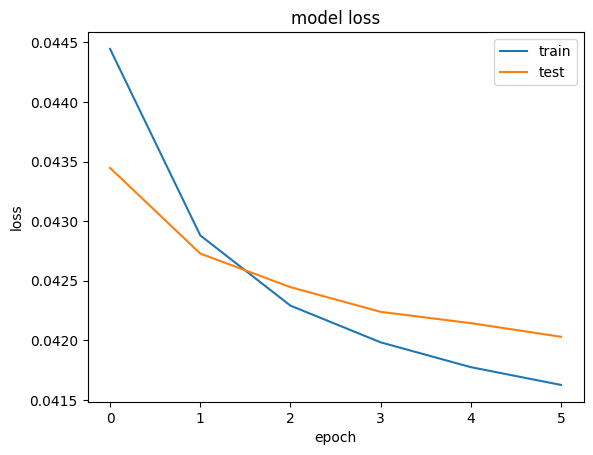

In [91]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()

In [92]:
# Test model
p , a = (model.predict([x_test[:15,0], x_test[:15,1]]) , y_test[:15])
print("ratings are Normalized between 0 and 1 (0.5 - 5.0)")
for i in range(len(p)):
    print("predicted rating is : "+ str(np.round(p[i],2)) +"        actual rating was : "+ str(round(a[i],2)) )
     

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
ratings are Normalized between 0 and 1 (0.5 - 5.0)
predicted rating is : [0.9]        actual rating was : 1.0
predicted rating is : [0.93]        actual rating was : 1.0
predicted rating is : [0.94]        actual rating was : 1.0
predicted rating is : [0.81]        actual rating was : 0.33
predicted rating is : [0.54]        actual rating was : 0.33
predicted rating is : [0.73]        actual rating was : 1.0
predicted rating is : [0.54]        actual rating was : 0.56
predicted rating is : [0.81]        actual rating was : 0.78
predicted rating is : [0.22]        actual rating was : 0.33
predicted rating is : [0.86]        actual rating was : 0.11
predicted rating is : [0.71]        actual rating was : 0.56
predicted rating is : [0.81]        actual rating was : 0.78
predicted rating is : [0.82]        actual rating was : 0.78
predicted rating is : [0.59]        actual rating was : 0.56
predicted rating is : [0.72]        actual rating was : 1.0


In [93]:
movie_df = pd.read_csv('Dataset/movies.csv')

# display recommendations
def get_recomendations(user_id):
      movies_watched_by_user = df[df.user_id == user_id]
      movies_not_watched = movie_df[
          ~movie_df["movie_id"].isin(movies_watched_by_user.movie_id.values)]["movie_id"]
      movies_not_watched = list(
          set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
      )
      movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched] #convert the movies_id's to corresponding indices
      user_encoder = user2user_encoded.get(user_id)
      user_movie_array = np.hstack(
          ([[user_id]] * len(movies_not_watched), movies_not_watched)
      ) #array with the user_id repeated for each movie in movies_not_watched

      ratings = model.predict([user_movie_array[:,0], user_movie_array[:,1]]).flatten()

      top_ratings_indices = ratings.argsort()[-10:][::-1] #ratings in descending order and gets the indices of the top 10 recommended movies.
      recommended_movie_ids = [
          movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
      ] #Using the indices of the top 10 movies, this converts the encoded movie IDs back into their original IDs using movie_encoded2movie.
    
      top_ratings = ratings[top_ratings_indices]
      print("Showing recommendations for user: {}".format(user_id))
      print("=" * 36)
      print("Movies with high ratings from user")
      print("-" * 34)

    #top 5 highest rated already watched movies
      top_movies_user = (
          movies_watched_by_user.sort_values(by="rating", ascending=False)
          .head(5)
          .movie_id.values
      ) 

     #retrieving the top 10 recommended movies from movie_df and printing out their titles, genres, and the predicted ratings for the user.
      movie_df_rows = movie_df[movie_df["movie_id"].isin(top_movies_user)]
      for row in movie_df_rows.itertuples():
          print(row.title, ":", row.genres)

      print("-" * 30)
      print(" Top 10 movie recommendations")
      print("-" * 30)
      recommended_movies = movie_df[movie_df["movie_id"].isin(recommended_movie_ids)]
      # for row in recommended_movies.itertuples():
      for idx, row in enumerate(recommended_movies.itertuples()): 
          print(f"{row.title} : {row.genres} | Predicted Rating: {top_ratings[idx]:.2f}")
          


In [94]:

#enter a user_id (between 1 - 610)
get_recomendations(1)

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Showing recommendations for user: 1
Movies with high ratings from user
----------------------------------
Sound of Music, The (1965) : Musical
One Flew Over the Cuckoo's Nest (1975) : Drama
Last Days of Disco, The (1998) : Drama
Christmas Story, A (1983) : Comedy|Drama
Awakenings (1990) : Drama
------------------------------
 Top 10 movie recommendations
------------------------------
Usual Suspects, The (1995) : Crime|Thriller | Predicted Rating: 0.91
Shawshank Redemption, The (1994) : Drama | Predicted Rating: 0.90
Godfather, The (1972) : Action|Crime|Drama | Predicted Rating: 0.89
Rear Window (1954) : Mystery|Thriller | Predicted Rating: 0.89
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950) : Film-Noir | Predicted Rating: 0.89
Wrong Trousers, The (1993) : Animation|Comedy | Predicted Rating: 0.89
Paths of Glory (1957) : Drama|War | Predicted Rating: 0.88
Raiders of the Lost Ark (1981) : Action|Adventure | Predicted Rating: 0.88
Seven Samurai (Th

In [95]:
# Evaluation of the model

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")


MAE: 0.1597265722702272


In [96]:
#  Compute RMSE
y_pred = model.predict([x_test[:,0], x_test[:,1]])
y_true =  y_test

rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result : {:.4f} RMSE'.format(rmse))

3126/3126 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


Testing Result : 0.2019 RMSE
